In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
import anchors
from poola import core as pool

import core_functions as fns

gpp.set_aesthetics(palette='Set2')


## Functions 

In [9]:
#Process data
#Modified from poola to add na = False parameter 
def group_pseudogenes(annotations, pseudogene_size,
                      gene_col, control_regex, seed=7):
    """
    Remap annotations dataframe such that control genes are grouped into
    pseudo-genes
    annotations: dataframe |
    pseudogene_size: int |
    gene_col: str |
    control_regex: list of str, regular expressions to identify groups of
        pseudogenes |
    seed: int, random seed for reproducible outputs |
    returns: dataframe of annotations with controls grouped into pseudogenes |
    """
    remapped_annotations = annotations.copy()
    genes = remapped_annotations[gene_col]
    control_remap = {}
    for regex in control_regex:
        control_genes = genes[genes.str.contains(regex,na=False)].to_list()
        np.random.seed(seed)
        np.random.shuffle(control_genes) # shuffle mutates existing variable
        n_controls = len(control_genes)
        for i in range(n_controls):
            gene = control_genes[i]
            # Use module to get the right number of groupings
            gene_number = i % np.ceil(n_controls / pseudogene_size)
            control_remap[gene] = regex + '_' + str(int(gene_number))
    remapped_annotations[gene_col] = remapped_annotations[gene_col].replace(control_remap)
    return remapped_annotations

def get_grouped_controls(df, control_name):
    '''
    Inputs:
    1. df: guide-gene annotation df 
    2. control_name: list of string identifiers for controls 
    Outputs:
    1. grouped_genes: controls grouped into pseudogenes with
    '''
    ungrouped_df = pd.DataFrame()
    for control in control_name:
        control_condition = (df['Gene Symbol'].str.contains(control, na=False))
        control_rows = df[control_condition]
        #if all controls have same Gene Symbol
        if len(set(control_rows['Gene Symbol'])) == 1:
            ungrouped_df = df.copy()
            # Give controls unique names before grouping 
            ungrouped_df.loc[control_condition, 'Gene Symbol'] = control + control_rows['Guide'] 
    
    ungrouped_genes = ungrouped_df.dropna()

    grouped_genes = group_pseudogenes(ungrouped_genes[['Guide', 'Gene Symbol']], pseudogene_size=4, gene_col='Gene Symbol', control_regex = control_name)

    #grouped_controls = pd.concat([LibA_grouped_genes, LibB_grouped_genes])

    return grouped_genes

    
def match_pseudogenes(df, guide_mapping, control_name):
    '''
    Inputs: 
    1. df: data frame to which grouped pseudogene annotations will be merged 
    2. guide_mapping: guide-gene annotation data frame
    3. control_name: list containing substrings that identify controls 
    '''
    grouped_genes = get_grouped_controls(guide_mapping, control_name)
    grouped_df = pd.merge(grouped_genes, df, on = 'Guide', how = 'outer', suffixes = ['', '_old'])
    grouped_df.loc[:,'Gene Symbol'] = grouped_df.loc[:,'Gene Symbol'].fillna(grouped_df['Gene Symbol_old'])
    grouped_df = grouped_df.drop('Gene Symbol_old', axis = 1)

    return grouped_df

def col_avg(df, gene_col = ['Gene Symbol'], col_name = ''):
    avg_df = df[gene_col].copy()
    if col_name == '':
        #library = get_df_name(df).split('_')[-1] #get library name from df name
        avg_col_name = 'avg'#+library
    else:
        avg_col_name = col_name
    avg_df[avg_col_name] = df.mean(axis = 1)
    return avg_df

## Data Summary

* Baggen et al.
* Cell line: Huh 7
* Library: Brunello

In [10]:
# Reads from GEO Submission GSE175666 
reads = pd.read_excel('Data/GSE175666_Huh7_Brunello_Daelemans_v2.xlsx', sheet_name='Huh7_Brunello_genomewide_reads')
reads


,Guide,Gene Symbol,pDNA,Control replicate A,Control replicate B,SARS-CoV-2 replicate A_low,SARS-CoV-2 replicate B_low,SARS-CoV-2 replicate A_high,SARS-CoV-2 replicate B_high
0,37012_1,37012,227,13,25,45,19,0.0,0.0
1,37012_2,37012,159,52,38,35,31,0.0,0.0
2,37012_3,37012,375,59,36,40,16,0.0,0.0
3,37012_4,37012,98,5,4,23,13,0.0,0.0
4,37135_1,37135,132,8,32,18,21,0.0,0.0
...,...,...,...,...,...,...,...,...,...
77307,ZZEF1_4,ZZEF1,365,26,44,53,6,0.0,0.0
77308,ZZZ3_1,ZZZ3,317,3,16,0,11,0.0,0.0
77309,ZZZ3_2,ZZZ3,427,32,31,65,46,0.0,0.0
77310,ZZZ3_3,ZZZ3,171,53,52,26,27,0.0,0.0


In [11]:
#Calculate lognorm
cols = reads.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(reads.dropna(), cols = cols)

#Average across replicates
base_lognorms = lognorms.copy()[['Guide', 'Gene Symbol', 'pDNA_lognorm']]
link_cols = ['Guide', 'Gene Symbol']

#Mock Condition
control_cols = link_cols + [col for col in lognorms.columns if 'Control' in col]
control_lognorms = lognorms[control_cols]
control_avg = col_avg(control_lognorms, gene_col = link_cols, col_name = 'Control_lognorm')

#Low-stringency Condition
low_cols = link_cols + [col for col in lognorms.columns if 'low' in col]
low_lognorms = lognorms[low_cols]
low_lognorms_avg = col_avg(low_lognorms, gene_col = link_cols, col_name = 'SARS-CoV-2_low_lognorm')

#High-stringency Condition
high_cols = link_cols + [col for col in lognorms.columns if 'high' in col]
high_lognorms = lognorms[high_cols]
high_lognorms_avg = col_avg(high_lognorms, gene_col = link_cols, col_name = 'SARS-CoV-2_high_lognorm')

sars_lognorms = pd.merge(low_lognorms_avg, high_lognorms_avg, on = link_cols, how = 'outer')

lognorms_clean1 = pd.merge(base_lognorms, control_avg, on = link_cols, how = 'outer')
lognorms_clean = pd.merge(lognorms_clean1, sars_lognorms, on = link_cols, how = 'outer')

lognorms_clean


,Guide,Gene Symbol,pDNA_lognorm,Control_lognorm,SARS-CoV-2_low_lognorm,SARS-CoV-2_high_lognorm
0,37012_1,37012,3.928298,3.212470,3.556265,0.0
1,37012_2,37012,3.454601,4.416254,3.705609,0.0
2,37012_3,37012,4.614603,4.467507,3.368910,0.0
3,37012_4,37012,2.836098,1.612256,2.877647,0.0
4,37135_1,37135,3.212781,3.084608,3.020872,0.0
...,...,...,...,...,...,...
77118,ZZEF1_4,ZZEF1,4.577221,4.042620,3.004584,0.0
77119,ZZZ3_1,ZZZ3,4.382930,2.133870,1.188576,0.0
77120,ZZZ3_2,ZZZ3,4.794759,3.945309,4.392727,0.0
77121,ZZZ3_3,ZZZ3,3.550306,4.644232,3.418389,0.0


## Quality Control
### Population Distributions

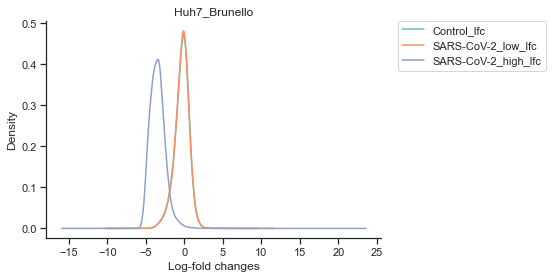

In [12]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms_clean.columns[-3:])
pDNA_lfc = fns.calculate_lfc(lognorms_clean,target_cols)
#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, initial_id = 'Control', res_id = 'SARS', filename = 'Huh7_Brunello')

### Control Distributions

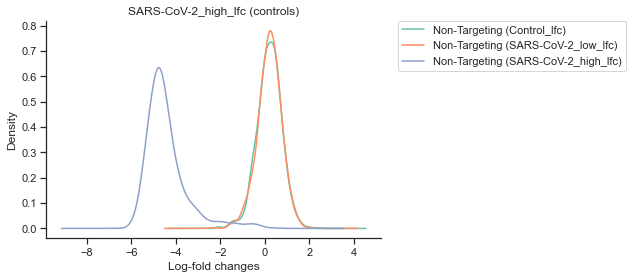

In [13]:
fns.control_dist_plot(pDNA_lfc, initial_id= 'Control', res_id='SARS', control_name=['Non-Targeting'], filename='Huh7_Brunello')

### ROC-AUC

Text(0, 0.5, 'True Positive Rate (essential)')

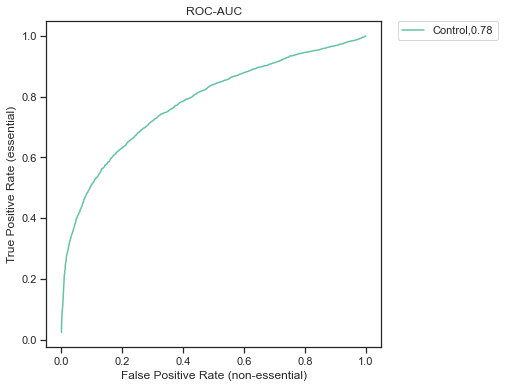

In [14]:
ess_genes, non_ess_genes = fns.get_gene_sets()

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col='Control_lfc')

fig,ax=plt.subplots(figsize=(6,6))
sns.lineplot(data=roc_df, x='fpr',y='tpr', ci=None, label = 'Control,' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene-level analysis

### Residual z-scores

In [15]:
#Calculate z-scores of lfc residuals
lfc_df = pDNA_lfc.copy().drop(['Gene Symbol'], axis = 1)
lfc_df = lfc_df.dropna()

guide_residuals_lfcs, all_model_info, model_fit_plots = fns.run_guide_residuals(lfc_df, initial_id= 'Control', res_id='SARS')

guide_mapping = pDNA_lfc[['Guide', 'Gene Symbol']]

gene_residuals = anchors.get_gene_residuals(guide_residuals_lfcs, guide_mapping)


              modified  unperturbed
0   SARS-CoV-2_low_lfc  Control_lfc
1  SARS-CoV-2_high_lfc  Control_lfc


In [16]:
gene_residual_sheet = fns.format_gene_residuals(gene_residuals, guide_min=3, guide_max=5)
guide_residual_sheet = pd.merge(guide_mapping, guide_residuals_lfcs, on = 'Guide', how = 'outer')

['SARS-CoV-2_high_lfc', 'SARS-CoV-2_low_lfc']
SARS-CoV-2_high_lfc
SARS-CoV-2_low_lfc


In [11]:
# with pd.ExcelWriter('../../Data/Processed/GEO_submission_v2/Huh7_Brunello_Daelemans_v2.xlsx') as writer:  
#     gene_residual_sheet.to_excel(writer, sheet_name='Huh7_Brunello_avg_zscore', index =False)
#     reads.to_excel(writer, sheet_name='Huh7_Brunello_genomewide_reads', index =False)
#     guide_mapping.to_excel(writer, sheet_name='Huh7_Brunello_guide_mapping', index =False)

In [12]:
# with pd.ExcelWriter('../../Data/Processed/Individual_screens_v2/Huh7_Brunello_Daelemans_v3.xlsx') as writer:   
#     gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
#     guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)